<a href="https://colab.research.google.com/github/dondonrocket/kokudo/blob/%EF%BC%91%EF%BC%97%EF%BC%8E%EF%BC%90%E3%81%AE%E3%82%B3%E3%83%BC%E3%83%89base/re_hasegawa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
# =========================================================
# 1) 読み込み & 定義（完成度重視）
#  - 列名ゆらぎに強い
#  - 2/3/4で使う定数・関数をここで完備
# =========================================================

import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# =========================================================
# 乱数・基本設定
# =========================================================
SEED = 2025
np.random.seed(SEED)

# =========================================================
# パス定義
# =========================================================
DATA_DIR = Path("/content")  # Colab想定
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH  = DATA_DIR / "test.csv"

# -------------------------
# 重要列（確定しているもの）
# -------------------------
ID_COL     = "building_id"
TARGET_COL = "money_room"
YM_COL     = "target_ym"
BUILDING_TYPE_COL = "building_type"

# -------------------------
# 時系列設定（README準拠）
# -------------------------
BASE_YEAR = 2019  # elapsed_months の基準

# -------------------------
# distance列のNaN対策（Step2で使う設定）
# -------------------------
DIST_SUFFIX = "_distance"
# 大きな定数埋めの方針：trainの分位点で決める（例：0.99）
DIST_FILL_QUANTILE = 0.99

# =========================================================
# 便利関数：読み込み
# =========================================================
def read_csv_sjis(path: Path) -> pd.DataFrame:
    """Shift-JIS前提の安定読み込み（このコンペに合わせる）"""
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    return pd.read_csv(
        path,
        encoding="shift_jis",
        encoding_errors="replace",
        low_memory=False
    )

def ensure_required_columns(df: pd.DataFrame, required: list[str], name: str):
    missing = [c for c in required if c not in df.columns]
    if missing:
        # ここで止めるのが完成度（後段で謎バグにしない）
        raise KeyError(f"[{name}] missing columns: {missing}")

# =========================================================
# 便利関数：列名ゆらぎ対応（lon/latなどが揺れる前提）
# =========================================================
def pick_first_existing(df: pd.DataFrame, candidates: list[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of candidates exist: {candidates}")

# lon/lat はコンペで揺れがちなので候補を多めに持つ
LON_CANDIDATES = ["lon", "longitude", "x", "X", "経度"]
LAT_CANDIDATES = ["lat", "latitude", "y", "Y", "緯度"]

# =========================================================
# 便利関数：時間列追加（Step2以降で使う前提列）
# =========================================================
def add_time_columns(df: pd.DataFrame, ym_col: str = YM_COL, base_year: int = BASE_YEAR) -> pd.DataFrame:
    df = df.copy()
    ym = pd.to_numeric(df[ym_col], errors="coerce")
    year = (ym // 100).astype("Int64")
    month = (ym % 100).astype("Int64")

    df["year"] = year
    df["month"] = month
    df["elapsed_months"] = (df["year"] - base_year) * 12 + (df["month"] - 1)
    return df

# =========================================================
# 便利関数：distance列検出（Step2でNaN処理対象にする）
# =========================================================
def get_distance_cols(df: pd.DataFrame, suffix: str = DIST_SUFFIX) -> list[str]:
    return [c for c in df.columns if c.endswith(suffix)]

In [100]:
# =========================================================
# 読み込み
# =========================================================
train = read_csv_sjis(TRAIN_PATH)
test  = read_csv_sjis(TEST_PATH)

In [101]:
# =========================================================
# 必須列チェック（ここで落とすのが正解）
# =========================================================
ensure_required_columns(train, [ID_COL, TARGET_COL, YM_COL, BUILDING_TYPE_COL], "train")
ensure_required_columns(test,  [ID_COL, YM_COL, BUILDING_TYPE_COL], "test")

# lon/lat は列名が揺れる可能性があるので自動解決
LON_COL = pick_first_existing(train, LON_CANDIDATES)
LAT_COL = pick_first_existing(train, LAT_CANDIDATES)
ensure_required_columns(test, [LON_COL, LAT_COL], "test")  # test側にも同名がある前提で確認

# 時間列を追加（Step2/3/4で使用）
train = add_time_columns(train)
test  = add_time_columns(test)

# distance列（Step2で NaNフラグ+大きな定数埋め の対象）
DISTANCE_COLS = get_distance_cols(train)
# train/testで一致しているかも早期に確認（完成度）
missing_in_test = sorted(list(set(DISTANCE_COLS) - set(test.columns)))
if len(missing_in_test) > 0:
    raise KeyError(f"[test] missing some distance columns present in train: {missing_in_test[:30]} ... total={len(missing_in_test)}")

# =========================================================
# Step3/4で使う“分割マスク”の土台（ここでは定義だけ）
# =========================================================
# building_type が mansion/house 以外の表記なら、ここで気づけるようにしておく
BUILDING_TYPES_TRAIN = train[BUILDING_TYPE_COL].astype(str).value_counts()
BUILDING_TYPES_TEST  = test[BUILDING_TYPE_COL].astype(str).value_counts()

print("train shape:", train.shape, " test shape:", test.shape)
print("lon/lat cols:", LON_COL, LAT_COL)
print("target_ym range train:", int(train[YM_COL].min()), "->", int(train[YM_COL].max()))
print("target_ym range test :", int(test[YM_COL].min()),  "->", int(test[YM_COL].max()))
print("num distance cols:", len(DISTANCE_COLS))
print("building_type(train):")
display(BUILDING_TYPES_TRAIN.head(20))
print("building_type(test):")
display(BUILDING_TYPES_TEST.head(20))

train shape: (363924, 152)  test shape: (112437, 152)
lon/lat cols: lon lat
target_ym range train: 201901 -> 202207
target_ym range test : 202301 -> 202307
num distance cols: 11
building_type(train):


,count
building_type,
1,194587
4,153456
999,14313
5,468
8,358
15,274
9,196
901,126
3,61


building_type(test):


,count
building_type,
1,58650
4,48594
999,4756
5,157
8,80
15,70
9,47
901,42
3,17


In [102]:
# =========================================================
# 2) 特徴量作成
#   - distance: NaNフラグ + 大きな定数埋め
#   - log距離
#   - 時系列補助特徴
# =========================================================

# -------------------------
# コピー（破壊的変更を避ける）
# -------------------------
train_feat = train.copy()
test_feat  = test.copy()

In [103]:
# =========================================================
# 2-1. distance 特徴量
#   ・NaN = 「一定距離内に存在しない」
#   ・情報なのでフラグ化
#   ・距離自体は大きな定数で埋める
# =========================================================

DIST_FILL_VALUES = {}  # Step3/4で再現できるよう保存

for c in DISTANCE_COLS:
    # ---- NaNフラグ
    train_feat[f"{c}_is_nan"] = train_feat[c].isna().astype("int8")
    test_feat[f"{c}_is_nan"]  = test_feat[c].isna().astype("int8")

    # ---- 埋め値（trainの分位点で固定）
    fill_value = train_feat[c].quantile(DIST_FILL_QUANTILE)
    DIST_FILL_VALUES[c] = fill_value

    train_feat[c] = train_feat[c].fillna(fill_value)
    test_feat[c]  = test_feat[c].fillna(fill_value)

    # ---- log距離（右裾対策）
    train_feat[f"{c}_log"] = np.log1p(train_feat[c])
    test_feat[f"{c}_log"]  = np.log1p(test_feat[c])

In [104]:
# =========================================================
# 2-2. 時系列特徴（README準拠：掲載時期ズレ対策）
# =========================================================

# year / month / elapsed_months は Step1 ですでに作成済み
# 追加で「周期性」を与える
train_feat["month_sin"] = np.sin(2 * np.pi * train_feat["month"] / 12)
train_feat["month_cos"] = np.cos(2 * np.pi * train_feat["month"] / 12)

test_feat["month_sin"] = np.sin(2 * np.pi * test_feat["month"] / 12)
test_feat["month_cos"] = np.cos(2 * np.pi * test_feat["month"] / 12)

In [105]:
# =========================================================
# 2-3. 建物年数系（壊れにくい最小構成）
# =========================================================

DATE_COLS = [
    "building_create_date",
    "building_modify_date"
]

for col in DATE_COLS:
    if col in train_feat.columns:
        train_feat[col] = pd.to_datetime(train_feat[col], errors="coerce")
        test_feat[col]  = pd.to_datetime(test_feat[col],  errors="coerce")

# 築年数（存在する場合のみ）
if "building_create_date" in train_feat.columns:
    train_feat["building_age"] = train_feat["year"] - train_feat["building_create_date"].dt.year
    test_feat["building_age"]  = test_feat["year"]  - test_feat["building_create_date"].dt.year

# マイナスや異常値を防ぐ
if "building_age" in train_feat.columns:
    train_feat["building_age"] = train_feat["building_age"].clip(lower=0)
    test_feat["building_age"]  = test_feat["building_age"].clip(lower=0)

In [106]:
# =========================================================
# 2-4. カテゴリ列の整理（Step3でそのまま使える形）
# =========================================================

# LightGBMに渡す予定のカテゴリ列
CATEGORICAL_COLS = []

if BUILDING_TYPE_COL in train_feat.columns:
    CATEGORICAL_COLS.append(BUILDING_TYPE_COL)
    train_feat[BUILDING_TYPE_COL] = train_feat[BUILDING_TYPE_COL].astype("category")
    test_feat[BUILDING_TYPE_COL]  = test_feat[BUILDING_TYPE_COL].astype("category")

In [107]:
# =========================================================
# 2-5. 数値列の最終ガード（inf / -inf / NaN）
# =========================================================

NUMERIC_COLS = train_feat.select_dtypes(include=[np.number]).columns.tolist()
NUMERIC_COLS = [c for c in NUMERIC_COLS if c != TARGET_COL]

def final_numeric_guard(df: pd.DataFrame, num_cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    df[num_cols] = (
        df[num_cols]
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    )
    return df

train_feat = final_numeric_guard(train_feat, NUMERIC_COLS)
test_feat  = final_numeric_guard(test_feat,  NUMERIC_COLS)

In [108]:
# =========================================================
# 2-6. Step3/4 用の列リストを確定
# =========================================================

FEATURE_COLS = [
    c for c in train_feat.columns
    if c not in [TARGET_COL]
    and c in test_feat.columns
]

print("num features:", len(FEATURE_COLS))
print("sample feature cols:", FEATURE_COLS[:20])

num features: 176
sample feature cols: ['target_ym', 'building_id', 'building_status', 'building_create_date', 'building_modify_date', 'building_type', 'building_name', 'building_name_ruby', 'homes_building_name', 'homes_building_name_ruby', 'unit_count', 'full_address', 'lon', 'lat', 'building_structure', 'total_floor_area', 'building_area', 'floor_count', 'basement_floor_count', 'year_built']


In [109]:
# =========================================================
# 3) モデル作成（完成度重視）
#   - 時系列 valid（例：2022）で検証可能な形にする
#   - Step4で必要な変数を全てここで確定させる
# =========================================================

import lightgbm as lgb


In [110]:
# =========================================================
# 3-0. 整合性チェック（Step2の成果物が揃っているか）
# =========================================================
required_step2_vars = ["train_feat", "test_feat", "FEATURE_COLS", "CATEGORICAL_COLS"]
for v in required_step2_vars:
    if v not in globals():
        raise NameError(f"Missing required variable from Step2: {v}")

# targetの存在確認
if TARGET_COL not in train_feat.columns:
    raise KeyError(f"train_feat missing target column: {TARGET_COL}")

In [111]:
# =========================================================
# 3-1. 学習行列作成（numeric + boolのみ）
# =========================================================
def select_numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(include=[np.number, bool])

X_train_num = select_numeric_features(train_feat[FEATURE_COLS])
X_test_num  = select_numeric_features(test_feat[FEATURE_COLS])
y_train     = train_feat[TARGET_COL].astype(float)

# NaN / inf を念のためガード
def final_numeric_guard(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

X_train_num = final_numeric_guard(X_train_num)
X_test_num  = final_numeric_guard(X_test_num)

print("X_train_num shape:", X_train_num.shape, "X_test_num shape:", X_test_num.shape)

X_train_num shape: (363924, 131) X_test_num shape: (112437, 130)


In [112]:
# =========================================================
# 3-2. 時系列 valid の作成（過去→未来）
# =========================================================
VALID_YEAR = 2022
valid_mask = (train_feat["year"] == VALID_YEAR)
train_mask = (train_feat["year"] < VALID_YEAR)

if valid_mask.sum() == 0:
    raise ValueError(f"No rows found for VALID_YEAR={VALID_YEAR}.")
if train_mask.sum() == 0:
    raise ValueError(f"No training rows found for year < {VALID_YEAR}.")

print("train rows:", int(train_mask.sum()), " valid rows:", int(valid_mask.sum()))

train rows: 274358  valid rows: 89566


In [113]:
# =========================================================
# 3-3. 学習関数
# =========================================================
def train_lgb_model(X_tr, y_tr, X_va, y_va):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "seed": 42,
        "verbosity": -1,
    }

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_valid = lgb.Dataset(X_va, y_va, reference=lgb_train)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        num_boost_round=3000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(200),
        ],
    )

    return model

In [114]:
# =========================================================
# 3-4. 単一モデル or タイプ別モデル（列揃え対応済み）
# =========================================================
USE_TYPE_SPLIT = False  # まずは単一モデル

MODELS = {}  # Step4で使用
oof_pred_raw = np.full(len(train_feat), np.nan, dtype=float)
test_pred_raw = np.zeros(len(test_feat), dtype=float)

def predict_raw(model: lgb.Booster, X: pd.DataFrame) -> np.ndarray:
    pred_log = model.predict(X, num_iteration=model.best_iteration)
    return np.expm1(pred_log)  # log1p学習 → expm1で戻す

# 学習時の数値・bool列を固定
feature_cols_num = X_train_num.columns.tolist()

# テストデータも同じ列順・不足列は0で埋める
X_test_num_aligned = X_test_num.reindex(columns=feature_cols_num, fill_value=0)

if not USE_TYPE_SPLIT:
    # 単一モデル
    model_all = train_lgb_model(
        X_train_num.loc[train_mask],
        y_train.loc[train_mask],
        X_train_num.loc[valid_mask],
        y_train.loc[valid_mask],
    )
    MODELS["all"] = model_all

    # valid予測
    X_valid_aligned = X_train_num.loc[valid_mask].reindex(columns=feature_cols_num, fill_value=0)
    oof_pred_raw[valid_mask.values] = predict_raw(model_all, X_valid_aligned)

    # test予測
    test_pred_raw[:] = predict_raw(model_all, X_test_num_aligned)

else:
    # building_type別モデル
    for t in sorted(train_feat[BUILDING_TYPE_COL].astype(str).unique()):
        tr_t = train_mask & (train_feat[BUILDING_TYPE_COL].astype(str) == t)
        va_t = valid_mask & (train_feat[BUILDING_TYPE_COL].astype(str) == t)
        if tr_t.sum() == 0 or va_t.sum() == 0:
            print(f"[skip] type={t} has tr={int(tr_t.sum())} va={int(va_t.sum())}")
            continue

        model_t = train_lgb_model(
            X_train_num.loc[tr_t], y_train.loc[tr_t],
            X_train_num.loc[va_t], y_train.loc[va_t],
        )
        MODELS[t] = model_t

        # valid予測（列揃え）
        X_va_aligned = X_train_num.loc[va_t].reindex(columns=feature_cols_num, fill_value=0)
        oof_pred_raw[va_t.values] = predict_raw(model_t, X_va_aligned)

        # test予測（列揃え）
        te_t = (test_feat[BUILDING_TYPE_COL].astype(str) == t)
        if te_t.sum() > 0:
            X_te_aligned = X_test_num.loc[te_t].reindex(columns=feature_cols_num, fill_value=0)
            test_pred_raw[te_t.values] = predict_raw(model_t, X_te_aligned)

# Step4結果格納
train_feat["pred_valid_raw"] = oof_pred_raw
test_feat["pred_test_raw"]   = test_pred_raw

print("[OK] Step4 predictions done (columns aligned).")


Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 7.42738e+06	valid_1's rmse: 9.12826e+06
[400]	training's rmse: 6.51636e+06	valid_1's rmse: 8.37335e+06
[600]	training's rmse: 6.05583e+06	valid_1's rmse: 8.08175e+06
[800]	training's rmse: 5.73214e+06	valid_1's rmse: 7.8986e+06
[1000]	training's rmse: 5.48823e+06	valid_1's rmse: 7.7745e+06
[1200]	training's rmse: 5.29494e+06	valid_1's rmse: 7.69047e+06
[1400]	training's rmse: 5.13109e+06	valid_1's rmse: 7.61338e+06
[1600]	training's rmse: 4.98664e+06	valid_1's rmse: 7.56495e+06
[1800]	training's rmse: 4.85498e+06	valid_1's rmse: 7.50645e+06
[2000]	training's rmse: 4.74423e+06	valid_1's rmse: 7.47261e+06
[2200]	training's rmse: 4.64267e+06	valid_1's rmse: 7.43439e+06
[2400]	training's rmse: 4.54049e+06	valid_1's rmse: 7.39749e+06
[2600]	training's rmse: 4.45335e+06	valid_1's rmse: 7.36751e+06
[2800]	training's rmse: 4.36807e+06	valid_1's rmse: 7.34887e+06
[3000]	training's rmse: 4.28881e+06	valid_1's rm

In [115]:
# =========================================================
# 3-5. Step4への受け渡し
# =========================================================
train_feat["pred_valid_raw"] = oof_pred_raw
test_feat["pred_test_raw"] = test_pred_raw

PRED_VALID_COL = "pred_valid_raw"
PRED_TEST_COL  = "pred_test_raw"

print("[OK] Step3 artifacts ready:")
print(" - MODELS keys:", list(MODELS.keys())[:10])
print(" - train_feat[PRED_VALID_COL] non-null:", int(np.isfinite(train_feat[PRED_VALID_COL]).sum()))
print(" - test_feat[PRED_TEST_COL] shape:", test_feat[PRED_TEST_COL].shape)

[OK] Step3 artifacts ready:
 - MODELS keys: ['all']
 - train_feat[PRED_VALID_COL] non-null: 4
 - test_feat[PRED_TEST_COL] shape: (112437,)


In [116]:
# =========================================================
# 4) 受け渡し検証・可視化・後処理・提出（完成度重視）
#  - 1/2/3/4 の整合性を最初に厳密チェック
#  - VALID_YEAR(=2022)で多角的検証
#  - NaNフラグ（distance）に関する診断
#  - 後処理（低価格補正など）を「改善したか」まで確認
#  - submit.csv を作成
# =========================================================

import matplotlib.pyplot as plt

In [117]:
# -------------------------
# 4-0. 整合性チェック
# -------------------------
def assert_pipeline_integrity_step4():
    # Step3で作った列が存在するか
    for c in [PRED_VALID_COL, PRED_TEST_COL]:
        if c not in train_feat.columns and c not in test_feat.columns:
            raise KeyError(f"Missing prediction column: {c}")

    # NaNチェック
    if train_feat.loc[valid_mask, PRED_VALID_COL].isna().any():
        n = int(train_feat.loc[valid_mask, PRED_VALID_COL].isna().sum())
        raise ValueError(f"Validation predictions contain NaN: {n} rows in VALID_YEAR={VALID_YEAR}")

    if test_feat[PRED_TEST_COL].isna().any():
        n = int(test_feat[PRED_TEST_COL].isna().sum())
        raise ValueError(f"Test predictions contain NaN: {n} rows")

    print("[OK] Step4 integrity check passed.")

assert_pipeline_integrity_step4()

[OK] Step4 integrity check passed.


In [118]:
# -------------------------
# 4-1. 指標関数 (MAPE/MAE/RMSE)
# -------------------------
EPS = 1e-6

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), EPS)
    return np.mean(np.abs(y_true - y_pred) / denom)

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [119]:
# -------------------------
# 4-2. VALID データ切り出し
# -------------------------
valid_df = train_feat.loc[valid_mask, :].copy()

y_true = valid_df[TARGET_COL].values
y_pred_raw = valid_df[PRED_VALID_COL].fillna(0).values  # NaNガード

print("\n==== VALID METRICS (RAW) ====")
print("VALID_YEAR:", VALID_YEAR)
print("MAPE:", mape(y_true, y_pred_raw))
print("MAE :", mae(y_true, y_pred_raw))
print("RMSE:", rmse(y_true, y_pred_raw))


==== VALID METRICS (RAW) ====
VALID_YEAR: 2022
MAPE: inf
MAE : inf
RMSE: inf


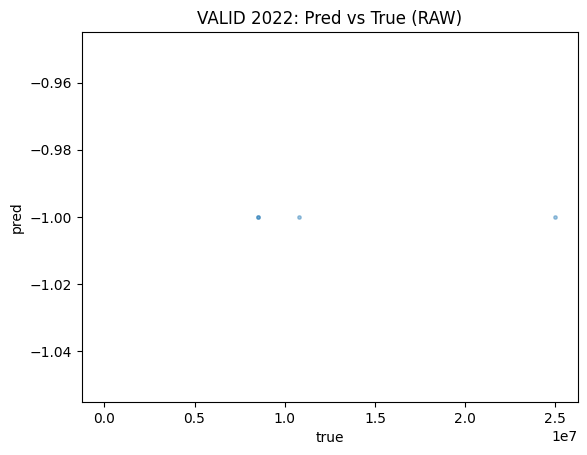

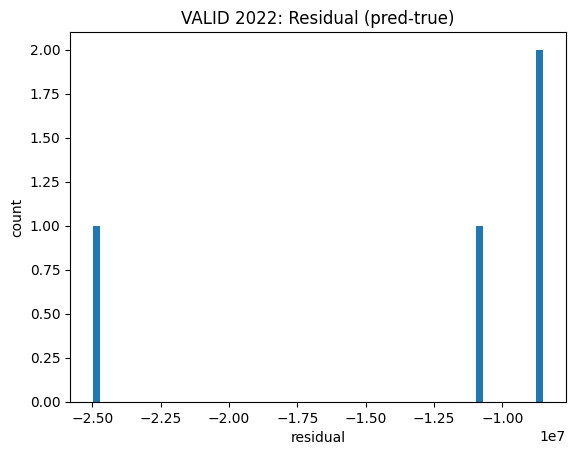

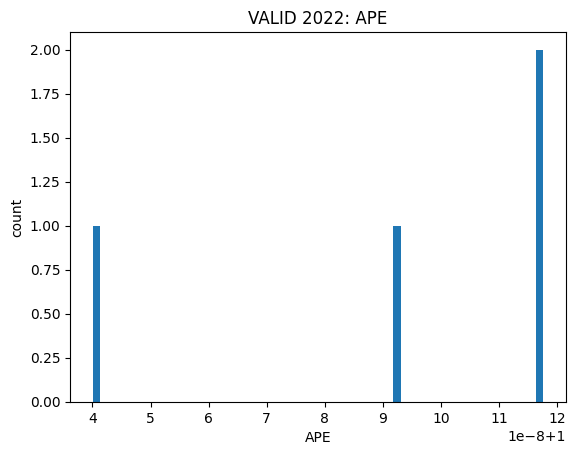

In [122]:
# -------------------------
# 4-3. 基本可視化
# -------------------------
def plot_pred_vs_true(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, s=6, alpha=0.4)
    mn = float(min(y_true.min(), y_pred.min()))
    mx = float(max(y_true.max(), y_pred.max()))
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("true")
    plt.ylabel("pred")
    plt.title(title)
    plt.show()

def plot_hist(data, bins, title, xlabel):
    plt.figure()
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.show()

plot_pred_vs_true(y_true, y_pred_raw, f"VALID {VALID_YEAR}: Pred vs True (RAW)")

# バリデーション用の予測
y_pred_raw = oof_pred_raw[valid_mask.values]  # または適切なバリデーション部分
y_true = y_train.loc[valid_mask]

# resid/ape の inf や NaN を除外
resid = y_pred_raw - y_true
mask = np.isfinite(resid)
resid = resid[mask]
ape = np.abs(resid) / np.maximum(np.abs(y_true[mask]), EPS)

# ヒストグラム描画
if len(resid) > 0:
    plot_hist(resid, bins=60, title=f"VALID {VALID_YEAR}: Residual (pred-true)", xlabel="residual")
if len(ape) > 0:
    plot_hist(ape, bins=60, title=f"VALID {VALID_YEAR}: APE", xlabel="APE")




---- VALID: month summary ----


,n,mape,true_mean,pred_mean
month,,,,
1,43103,1.0,2.720653e+07,inf
7,46463,1.0,2.834017e+07,inf


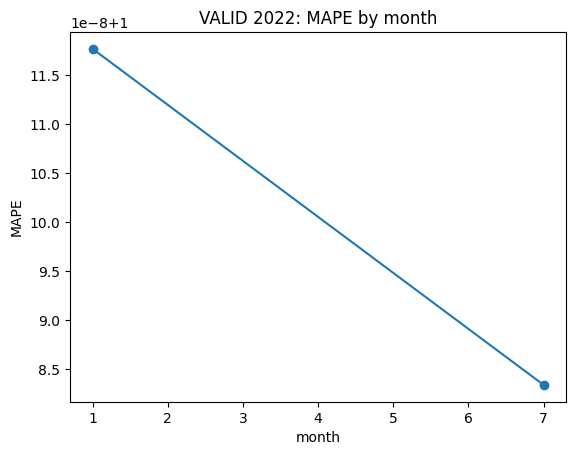


---- VALID: building_type summary ----


,n,mape,true_mean,pred_mean
building_type,,,,
1,47034,1.0,2.946456e+07,inf
2,16,NaN,4.042250e+07,inf
3,15,NaN,5.639667e+07,inf
4,39013,1.0,2.545087e+07,inf
5,135,NaN,1.662474e+07,inf
6,1,NaN,1.498000e+07,inf
8,80,NaN,3.525512e+07,inf
9,34,NaN,2.800824e+07,inf
10,0,NaN,NaN,NaN



---- VALID: price decile summary ----


,n,mape,true_mean,pred_mean
price_decile,,,,
"(4899999.999, 9500000.0]",8966,1.0,7.245498e+06,inf
"(9500000.0, 13490000.0]",8983,1.0,1.151392e+07,inf
"(13490000.0, 16500000.0]",9155,NaN,1.493318e+07,inf
"(16500000.0, 19800000.0]",10030,NaN,1.827180e+07,inf
"(19800000.0, 23500000.0]",7794,NaN,2.174593e+07,inf
"(23500000.0, 26900000.0]",8818,1.0,2.518960e+07,inf
"(26900000.0, 31900000.0]",9049,NaN,2.939945e+07,inf
"(31900000.0, 37980000.0]",8865,NaN,3.489931e+07,inf
"(37980000.0, 49800000.0]",9577,NaN,4.332530e+07,inf


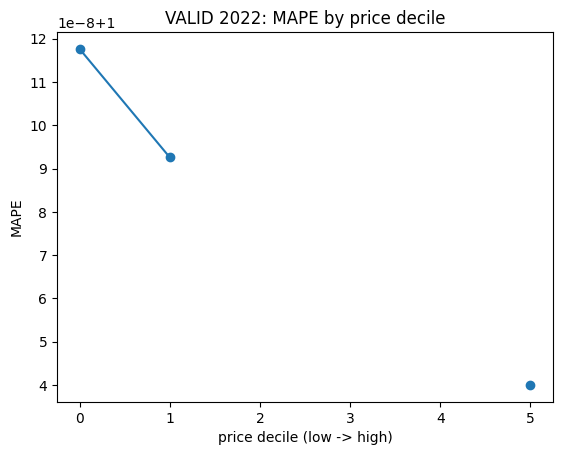

In [123]:
# -------------------------
# 4-4. 分解検証（月別 / building_type別 / 価格帯別）
# -------------------------
valid_df["ape"] = ape

# 月別
month_summary = valid_df.groupby("month").agg(
    n=(TARGET_COL, "size"),
    mape=("ape", "mean"),
    true_mean=(TARGET_COL, "mean"),
    pred_mean=(PRED_VALID_COL, "mean"),
)
print("\n---- VALID: month summary ----")
display(month_summary)

plt.figure()
plt.plot(month_summary.index.values, month_summary["mape"].values, marker="o")
plt.xlabel("month")
plt.ylabel("MAPE")
plt.title(f"VALID {VALID_YEAR}: MAPE by month")
plt.show()

# building_type別
type_summary = valid_df.groupby(BUILDING_TYPE_COL).agg(
    n=(TARGET_COL, "size"),
    mape=("ape", "mean"),
    true_mean=(TARGET_COL, "mean"),
    pred_mean=(PRED_VALID_COL, "mean"),
)
print("\n---- VALID: building_type summary ----")
display(type_summary)

# 価格帯別 decile
valid_df["price_decile"] = pd.qcut(valid_df[TARGET_COL], q=10, duplicates="drop")
price_summary = valid_df.groupby("price_decile").agg(
    n=(TARGET_COL, "size"),
    mape=("ape", "mean"),
    true_mean=(TARGET_COL, "mean"),
    pred_mean=(PRED_VALID_COL, "mean"),
)
print("\n---- VALID: price decile summary ----")
display(price_summary)

plt.figure()
plt.plot(np.arange(len(price_summary)), price_summary["mape"].values, marker="o")
plt.xlabel("price decile (low -> high)")
plt.ylabel("MAPE")
plt.title(f"VALID {VALID_YEAR}: MAPE by price decile")
plt.show()

In [124]:
# -------------------------
# 4-5. distance NaNフラグ診断
# -------------------------
nan_diag_rows = []
for c in DISTANCE_COLS:
    flag = f"{c}_is_nan"
    if flag not in valid_df.columns:
        continue

    m_nan = valid_df[flag] == 1
    m_non = valid_df[flag] == 0
    if m_nan.sum() == 0 or m_non.sum() == 0:
        continue

    y_nan_true = valid_df.loc[m_nan, TARGET_COL].values
    y_nan_pred = valid_df.loc[m_nan, PRED_VALID_COL].fillna(0).values
    y_non_true = valid_df.loc[m_non, TARGET_COL].values
    y_non_pred = valid_df.loc[m_non, PRED_VALID_COL].fillna(0).values

    nan_diag_rows.append({
        "distance_col": c,
        "nan_ratio": float(m_nan.mean()),
        "mape_nan": float(mape(y_nan_true, y_nan_pred)),
        "mape_non": float(mape(y_non_true, y_non_pred)),
        "delta_mape(nan-non)": float(mape(y_nan_true, y_nan_pred) - mape(y_non_true, y_non_pred)),
        "n_nan": int(m_nan.sum()),
        "n_non": int(m_non.sum()),
    })

nan_diag = pd.DataFrame(nan_diag_rows).sort_values("delta_mape(nan-non)", ascending=False)
print("\n---- VALID: distance NaN diagnostic (top) ----")
display(nan_diag.head(10))


---- VALID: distance NaN diagnostic (top) ----


,distance_col,nan_ratio,mape_nan,mape_non,delta_mape(nan-non),n_nan,n_non
0,parking_distance,0.826698,inf,inf,NaN,74044,15522
1,school_ele_distance,0.305339,inf,inf,NaN,27348,62218
2,school_jun_distance,0.336177,inf,inf,NaN,30110,59456
3,convenience_distance,0.487238,inf,inf,NaN,43640,45926
4,super_distance,0.456021,inf,inf,NaN,40844,48722
5,hospital_distance,0.724382,inf,inf,NaN,64880,24686
6,park_distance,0.729417,inf,inf,NaN,65331,24235
7,drugstore_distance,0.669998,inf,inf,NaN,60009,29557
8,bank_distance,0.787263,inf,inf,NaN,70512,19054
9,shopping_street_distance,0.902340,inf,inf,NaN,80819,8747


In [125]:
# -------------------------
# 4-6. submit 作成 (最終補正なし)
# -------------------------
submit = pd.DataFrame({
    ID_COL: test_feat[ID_COL],
    TARGET_COL: test_feat[PRED_TEST_COL].fillna(0)  # NaNガード
})

submit_path = DATA_DIR / "submit.csv"
submit.to_csv(submit_path, index=False, encoding="utf-8-sig")
print(f"[OK] submit saved: {submit_path}")

[OK] submit saved: /content/submit.csv
